ПІДГОТОВКА ДАНИХ

In [1]:
#імпорт бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
#Завантаження даних
df = pd.read_csv('Student_Performance.csv')

In [3]:
#Розвідковий аналіз
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [4]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [5]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

<Axes: >

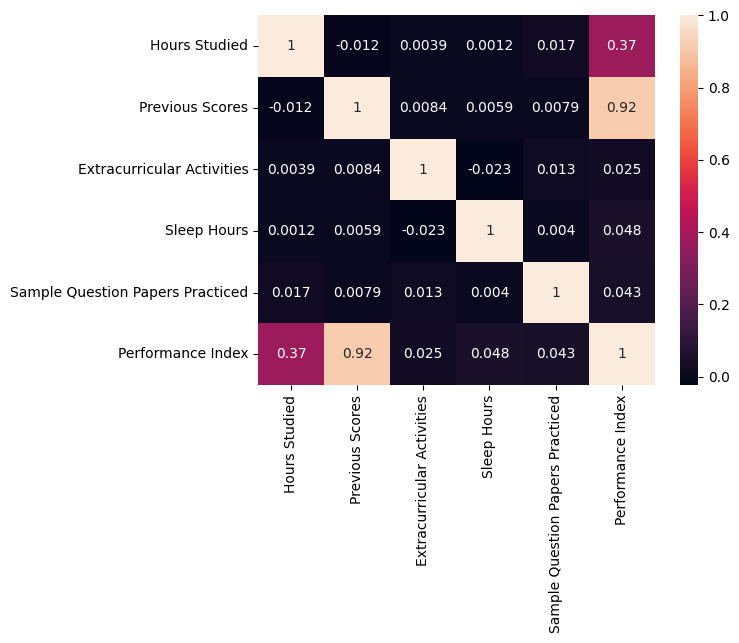

In [6]:
#Обробка категоріальних змінних
encoder = LabelEncoder()
df['Extracurricular Activities'] = encoder.fit_transform(df['Extracurricular Activities'])
#Побудова теплової карти кореляцій
sns.heatmap(df.corr(), annot=True)

In [7]:
#Вибір ознак і цільової змінної
y = df['Performance Index']
X = df.drop('Performance Index', axis=1)
#Поділ на навчальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#Нормалізація
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_final = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]

РЕАЛІЗАЦІЯ МЕТОДУ ГРАДІЄНТНОГО СПУСКУ

In [9]:
#Ініціалізація параметрів
b = np.zeros(X_train_final.shape[1])
#Гіперпараметри
epochs=1000
learning_rate=0.01

In [10]:
#Обчислення функції втрат
def compute_cost(X, y, b):
    predictions = X.dot(b)
    errors = predictions - y
    mse = (1 / len(y)) * np.sum(errors ** 2)
    return mse

#Функція градієнтного спуску
def gradient_descent(X, y, b, learning_rate, epochs):
    cost_history = []
    m = len(y)
    for _ in range(epochs):
        y_pred = X.dot(b)
        error = y_pred - y
        gradient = (1/m) * X.T.dot(error)
        b = b - learning_rate * gradient
        mse = (1/m) * np.sum(error ** 2)
        cost_history.append(mse)
    return b, cost_history

b = [55.30911213  7.40093109 17.63646538  0.30430629  0.81002051  0.54895455]


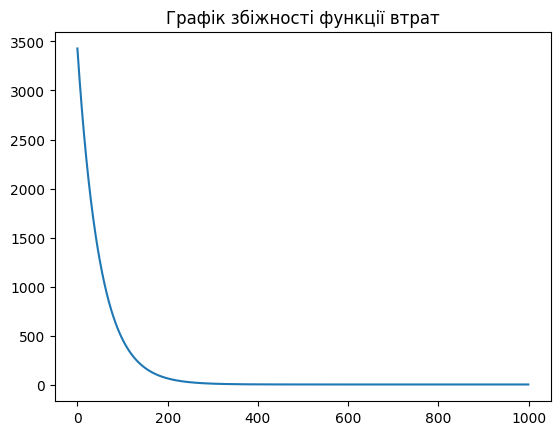

In [11]:
#Навчання моделі
b_final, cost_history = gradient_descent(X_train_final, y_train, b, learning_rate, epochs)
print('b =',b_final)
#Побудова графіка cost_history по ітераціях
plt.plot(cost_history)#, label = 'Графік збіжності функції втрат')
plt.title('Графік збіжності функції втрат')
plt.show()

ОЦІНКА ЯКОСТИ МОДЕЛІ НА ТЕСТОВИХ ДАНИХ

In [12]:
#Прогнозування
y_pred = X_test_final.dot(b_final)
#Розрахунок метрик
mse_test = np.mean((y_test - y_pred) ** 2)
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
print('MSE =', mse_test)
print('R2 =', r2)

MSE = 4.082454883009034
R2 = 0.9889837591777187


ПЕРЕВІРКА ПРИПУЩЕНЬ КЛАСИЧНОЇ ЛІНІЙНОЇ РЕГРЕСІЇ

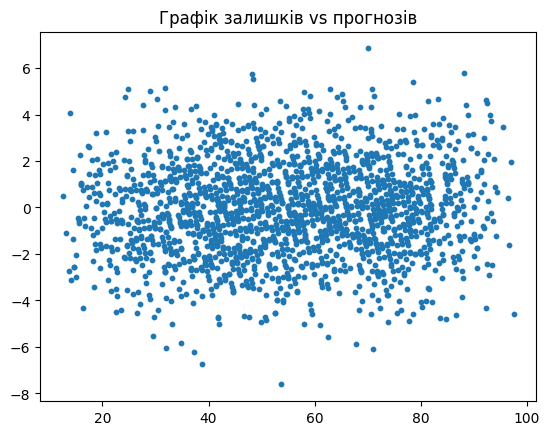

In [13]:
#Лінійність зв'язку
#Гомоскедастичність
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, s=10)
plt.title('Графік залишків vs прогнозів')
plt.show()

In [14]:
#Відсутність мультиколінеарності
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_scaled_no_intercept = X_train_scaled
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled_no_intercept, i) 
                    for i in range(X_scaled_no_intercept.shape[1])]
print(vif_data)

                            Feature       VIF
0                     Hours Studied  1.000387
1                   Previous Scores  1.000243
2        Extracurricular Activities  1.000428
3                       Sleep Hours  1.000461
4  Sample Question Papers Practiced  1.000320


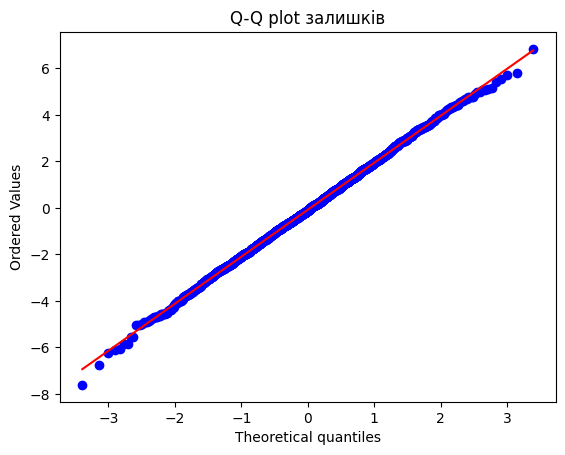

In [15]:
#Нормальність залишків
scipy.stats.probplot(residuals, plot=plt)
plt.title('Q-Q plot залишків')
plt.show()

In [16]:
#Відсутність автокореляції залишків
from statsmodels.stats.stattools import durbin_watson
durbin_watson(residuals)

2.047384214253771

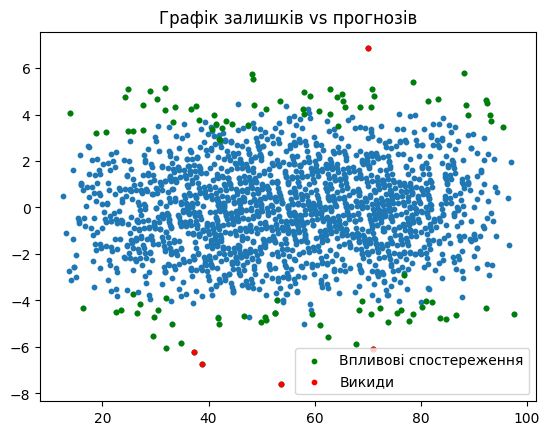

In [17]:
#Відсутність викидів та впливових спостережень
import statsmodels.api as sm
threshold = 3 * np.std(residuals)
outliers = np.abs(residuals) > threshold
X_test_sm = sm.add_constant(X_test_scaled)
model_sm = sm.OLS(y_test, X_test_sm).fit()
influence = model_sm.get_influence()
cooks_d = influence.cooks_distance[0]
n = len(y_test)
influential_points = cooks_d > 4/n
plt.scatter(y_pred, residuals, s=10)
plt.scatter(y_pred[influential_points], residuals[influential_points], color='green', s=10, label='Впливові спостереження')
plt.scatter(y_pred[outliers], residuals[outliers], color='red', s=10, label='Викиди')
plt.title('Графік залишків vs прогнозів')
plt.legend()
plt.show()

Перевірка припущень класичної лінійної регресії (лінійність зв'язку, відсутність мультиколінеарности, нормальність залишків, гомоскедастичність, відсутність автокореляції залишків) підтвердила надійність побудованої моделі. Отже, вона придатна для прогнозування успішности студентів на основі даних про час навчання, попередні бали, участь у додаткових активностях, час сну та виконання завдань.